<a href="https://colab.research.google.com/github/Emmaka9/antimicrobial-peptides-prediction/blob/main/peptide_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting Activity of Short Antimicrobial Peptides**


# **Install conda**

In [68]:
# uninstall previous sklearn and install sklearn version 0.23.1 which is a requirement for lazypredict that we used later in the project
!pip uninstall s -y
!pip install scikit-learn==0.23.1

In [69]:
import sklearn
sklearn.__version__ # check sklearn version to make sure

'0.23.1'

In [70]:
################################################################################
# INSTALL CONDA ON GOOGLE COLAB
################################################################################
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

# **Download and Install Pfeature**
Pfeature computes the properties of the amino acids, which in turn molecular properties of the peptides since peptides are just short stretches of amino acids (usually ranges from 2(dipeptide) to more than 50). We use these properties as features for our machine learning model.

In [71]:
! wget https://github.com/raghavagps/Pfeature/raw/master/PyLib/Pfeature.zip

In [72]:
! unzip Pfeature.zip # unzip the pfeture library

In [73]:
#change directory into the unzipped Pfeature library
% cd Pfeature

In [74]:
# install the pfeature library using the python setup.py i.e manually, since the pfeature library isn't availble on pip
! python setup.py install

# **Install CD-HIT**

CD-HIT library helps to get rid of any redundancy in the peptide sequences.
We use conda to install CD-HIT.

In [75]:
# install cd-hit using conda
! conda install -c bioconda cd-hit -y

# **Load peptide dataset**

The dataset format is in `fasta` format.</br>
**Fasta** format is ASCII text file that represents amino acid(protein) or nucleotide sequences, in which nucleotides and amino acids are represented by single-letter codes. Sequence names and comments can be placed in front of the sequences in this format. It has become a near universal standard in bioinformatics.

The description line or header/identifier line begins with `>`, gives a name and/or a unique identifer for the sequence, and can also contain additional information.

For example, in following is a peptide with 26 aa
```
>nonamp5_30_1387
GLPICGETCFKTKCYTKGCSCSYPVCKRN
```
Here, `>` marks the beginning, `nonamp5_30_1387` is the identifier of the peptide. **nonamp** mean there is no antimicrobial activity, i.e. it is an example from the negative data.

In [76]:
# download the positive training data
! wget https://raw.githubusercontent.com/Emmaka9/antimicrobial-peptides-prediction/main/dataset/train_set/train_po.fasta

In [77]:
# download the negative training data
! wget https://raw.githubusercontent.com/Emmaka9/antimicrobial-peptides-prediction/main/dataset/train_set/train_ne.fasta

In [78]:
# download the positive test data
! wget https://raw.githubusercontent.com/Emmaka9/antimicrobial-peptides-prediction/main/dataset/test_set/test_po.fasta

In [79]:
# download the negative test data
! wget https://raw.githubusercontent.com/Emmaka9/antimicrobial-peptides-prediction/main/dataset/test_set/test_ne.fasta

In [80]:
# print negative training data using bash command "cat"
! cat test_ne.fasta

# **Remove redundant sequences using CD-HIT**

In [81]:
# remove peptides sequences with peptide similarity > 0.99 from train_po.fasta
! cd-hit -i train_po.fasta -o train_po_cdhit.txt -c 0.99

In [82]:
# remove peptides sequences with peptide similarity > 0.99 from train_po.fasta
! cd-hit -i train_ne.fasta -o train_ne_cdhit.txt -c 0.99

In [83]:
! cd-hit -i test_po.fasta -o test_po_cdhit.txt -c 0.99

In [84]:
! cd-hit -i test_ne.fasta -o test_ne_cdhit.txt -c 0.99

In [85]:
! ls -l

In [86]:
# number of peptides in train_po, after CD-HIT
! grep ">" train_po_cdhit.txt | wc -l

In [87]:
# number of peptides in train_po, before CD-HIT
! grep ">" train_po.fasta | wc -l

In [88]:
# number of peptides in train_ne, before CD-HIT
! grep ">" train_ne.fasta | wc -l

In [89]:
# number of peptides in train_ne, after CD-HIT
! grep ">" train_ne_cdhit.txt | wc -l

# **Calculate features using the Pfeature library**

Feature classes provided by Pfeature is summarized in the tables below.

**Composition Based Features**

Feature claass | Description | Function
---|---|---
AAC | Amino acid composition | aac_wp
DPC | Dipeptide composition | dpc_wp
TPC | Tripeptide composition | tpc_wp
ABC | Atom and bond composition | atc_wp, btc_wp
PCP | Physico-chemical properties | pcp_wp
AAI | Amino acid index composition | aai_wp
RRI | Repetitive Residue Information | rri_wp
DDR | Distance distribution of residues |ddr_wp
PRI | Physico-chemical properties repeat composition | pri_wp
SEP | Shannon entropy | sep_wp
SER | Shannon entropy of residue level | ser_wp
SPC | Shannon entropy of physicochemical property | spc_wp
ACR | Autocorrelation | acr_wp
CTC | Conjoint Triad Calculation | ctc_wp
CTD | Composition enhanced transition distribution | ctd_wp
PAAC | Pseudo amino acid composition | paac_wp
APAAC | Amphiphilic pseudo amino acid composition | apaac_wp
QSO | Quasi sequence order | qos_wp
SOC | Sequence order coupling | soc_wp

[Pfeature Manual](https://webs.iiitd.edu.in/raghava/pfeature/Pfeature_Manual.pdf)

### **Define functions for calculating the different features**

In [90]:
import pandas as pd

In [91]:
!pwd


**aac_wp**: computes the percentage composition of each amino-acid in a peptide.
E.g. MISDSQIFVALLFALVSAVLAIRLGTDLYQ is peptide. It has 30 amino acid, and
3 S (Serine). So, the percentage compostion of S is (3/30) = 0.1 = 10%

**Pseudo code of the funciton to compute features:**
* convert the fasta data file into a csv file
* apply aac_wp function from Pfeature.pfeature on the input file, and write its output on the csv file
* read the output csv file in a pandas dataframe
* return the dataframe


In [92]:
# calculate Amino acid composition (AAC) for the whole peptide
#aac_wp : Amino acid composition_whole peptide 

'''
aac_wp: computes the percentage composition of each amino-acid in a peptide.
E.g. MISDSQIFVALLFALVSAVLAIRLGTDLYQ is peptide. It has 30 amino acid, and
3 S (Serine). So, the percentage compostion of S is (3/30) = 0.1 = 10%
'''

from Pfeature.pfeature import aac_wp # import aac_wp func to compute aac_wp

'''
Function: definition to compute aac_wp
Parameter: input - will be a fasta file of the peptides after performing the CD-HIT

'''
def aac(input):
  a = input.rstrip('txt') #strip the .txt from the file name
  output = a + 'aac.csv' # add aac.csv at the end of the file: rename the file
  df_out = aac_wp(input, output) # apply aac_wp on the input file, which will spit out the output in the output file with extension aac.csv
  df_in = pd.read_csv(output) # read the output file as pandas dataframe
  return df_in # return the dataframe

aac('test_ne_cdhit.txt')

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,0.00,0.00,0.00,0.00,0.00,9.09,18.18,9.09,0.00,0.00,0.00,18.18,0.00,9.09,0.00,9.09,0.00,0.00,0.00,27.27
1,10.53,0.00,5.26,0.00,5.26,15.79,0.00,15.79,0.00,5.26,5.26,5.26,10.53,0.00,5.26,0.00,15.79,0.00,0.00,0.00
2,6.67,0.00,0.00,6.67,6.67,20.00,0.00,0.00,0.00,6.67,6.67,6.67,0.00,20.00,0.00,0.00,0.00,13.33,0.00,6.67
3,25.00,0.00,0.00,14.29,0.00,10.71,0.00,3.57,0.00,0.00,3.57,0.00,7.14,3.57,0.00,32.14,0.00,0.00,0.00,0.00
4,11.76,0.00,0.00,5.88,0.00,5.88,0.00,17.65,23.53,11.76,0.00,5.88,0.00,0.00,0.00,5.88,0.00,5.88,5.88,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,7.14,0.00,3.57,3.57,10.71,0.00,0.00,0.00,7.14,10.71,0.00,10.71,10.71,7.14,3.57,7.14,3.57,3.57,0.00,10.71
90,7.69,0.00,0.00,0.00,7.69,15.38,0.00,0.00,15.38,7.69,0.00,0.00,0.00,7.69,0.00,7.69,15.38,7.69,0.00,7.69
91,0.00,0.00,0.00,6.67,6.67,6.67,6.67,6.67,13.33,0.00,0.00,6.67,6.67,6.67,0.00,6.67,6.67,20.00,0.00,0.00
92,10.34,0.00,3.45,3.45,3.45,13.79,3.45,13.79,0.00,17.24,3.45,0.00,0.00,0.00,3.45,6.90,3.45,13.79,0.00,0.00


In [93]:
# Dipeptide composition (DPC)

from Pfeature.pfeature import dpc_wp

def dpc(input):
  a = input.rstrip('txt') #strip the .txt from the file name
  output = a + 'dpc.csv' # add aac.csv at the end of the file: rename the file
  df_out = dpc_wp(input, output, 1) # apply aac_wp on the input file, which will spit out the output in the output file with extension aac.csv
  df_in = pd.read_csv(output) # read the output file as pandas dataframe
  return df_in # return the dataframe

#dpc('train_po_cdhit.txt')


### **Calculate feature for both positive and negative classes + combines the two classes + merge with class labels**

In [94]:
'''
Function definition feature_calc:
    1. calculate features for both positive and negative classes of data
    2. concatenate the both pos and neg classes of data stacked on top of each other
    3. merge with class labels
'''

def feature_calc(po, ne, feature_name):
  # pass in the pos file to feature_name function(aac) to Calculate feature
  po_feature = feature_name(po)
  # pass in the pos file to feature_name function(aac) to Calculate feature
  ne_feature = feature_name(ne)
  # Create class labels in pandas series
  po_class = pd.Series(['positive' for i in range(len(po_feature))])
  ne_class = pd.Series(['negative' for i in range(len(ne_feature))])
  # concatenate pos and neg classes stacked on top of each other (axis=0)
  po_ne_class = pd.concat([po_class, ne_class], axis=0)
  po_ne_class.name = 'class' # set the series name class
  # concatenate pos and neg features
  po_ne_feature = pd.concat([po_feature, ne_feature], axis=0)
  # concatenate feature and class
  df = pd.concat([po_ne_feature, po_ne_class], axis=1)
  return df


'''
feature_train and feature_test are pandas dataframe with 21 columns derived using aac_wp on training data and test data respectively.

'''
pos = 'train_po_cdhit.txt'
neg = 'train_ne_cdhit.txt'
feature_train = feature_calc(pos, neg, aac) # calculate features on training data
#feature = feature_calc(pos, neg, dpc) # DPC
feature_test = feature_calc('test_po_cdhit.txt', 'test_ne_cdhit.txt', aac) # calculate features on test data


# **Data pre-processing**

Convert data into a format that we can use to fit into the model (train the model)
* create dataframe X_train and X_test using the features
* y_train and y_test using the class labels

In [95]:
feature_test # print feature_test

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,...,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y,class
0,12.00,0.00,0.00,8.00,0.00,16.00,0.00,0.00,0.00,16.00,...,0.00,4.00,8.00,8.00,12.00,12.00,0.00,4.00,0.00,positive
1,6.25,0.00,6.25,0.00,6.25,18.75,0.00,12.50,12.50,12.50,...,0.00,0.00,0.00,0.00,6.25,0.00,18.75,0.00,0.00,positive
2,0.00,0.00,4.55,0.00,0.00,13.64,0.00,0.00,9.09,4.55,...,4.55,0.00,4.55,31.82,0.00,9.09,4.55,9.09,0.00,positive
3,30.77,0.00,0.00,0.00,7.69,0.00,0.00,0.00,30.77,30.77,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,positive
4,17.39,0.00,0.00,0.00,0.00,13.04,0.00,8.70,17.39,21.74,...,0.00,0.00,0.00,0.00,0.00,8.70,13.04,0.00,0.00,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,7.14,0.00,3.57,3.57,10.71,0.00,0.00,0.00,7.14,10.71,...,10.71,10.71,7.14,3.57,7.14,3.57,3.57,0.00,10.71,negative
90,7.69,0.00,0.00,0.00,7.69,15.38,0.00,0.00,15.38,7.69,...,0.00,0.00,7.69,0.00,7.69,15.38,7.69,0.00,7.69,negative
91,0.00,0.00,0.00,6.67,6.67,6.67,6.67,6.67,13.33,0.00,...,6.67,6.67,6.67,0.00,6.67,6.67,20.00,0.00,0.00,negative
92,10.34,0.00,3.45,3.45,3.45,13.79,3.45,13.79,0.00,17.24,...,0.00,0.00,0.00,3.45,6.90,3.45,13.79,0.00,0.00,negative


In [96]:
# Assigns the features(train/test)  to X(train/test) and class label(train/test)  to Y(train/test) 
X_train = feature_train.drop('class', axis=1) # drop the column 'class' of the feature_train dataframe and assign it to X_train; 
X_test = feature_test.drop('class', axis=1) # drop the column 'class' of the feature_test df and assign it to X_train;

y_train = feature_train['class'].copy() # copy the column 'class' of feature_train and assign it to y_train
y_test = feature_test['class'].copy() # copy the column 'class' of feature_test and assign it to y_test

In [97]:
# Encoding the Y class label
# Encode the value 'positive' to 1 and 'negative' to 0
y_train = y_train.map({"positive": 1, "negative": 0}) # map all the positive values of y_train to 1 and negative values of y_train to 0
y_test = y_test.map({"positive": 1, "negative": 0}) # map all the positive values of y_test to 1 and negative values of y_test to 0

In [98]:
X_train.shape # print the shape of X_train

(2759, 20)

In [99]:
# Feature selection (Variance threshold)
from sklearn.feature_selection import VarianceThreshold
# remove features that have low variance (0.1)
fs = VarianceThreshold(threshold=0.1) #set variance threshold 0.1
# perform fit and transform by using VarianceThreshold on both X_train and X_test at a single time and converts the data points
fs.fit_transform(X_train) 
fs.fit_transform(X_test)

#X2.shape
# keep all the rows but replace the columns with features > variance threshold for both X_train and X_test
X_train2 = X_train.loc[:, fs.get_support()]
X_test2 = X_test.loc[:, fs.get_support()]
X_train2 # print X_train2

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,27.27,0.00,9.09,0.00,9.09,9.09,0.00,0.00,0.00,0.00,0.00,9.09,9.09,0.00,0.00,0.00,0.00,18.18,0.00,9.09
1,0.00,54.55,0.00,9.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.18,18.18,0.00,0.00,0.00
2,0.00,0.00,9.09,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,0.00,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
3,0.00,0.00,0.00,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
4,0.00,0.00,9.09,18.18,18.18,9.09,0.00,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,13.33,0.00,3.33,3.33,0.00,13.33,0.00,3.33,26.67,10.00,3.33,3.33,3.33,3.33,0.00,0.00,3.33,0.00,10.00,0.00
1418,6.67,0.00,0.00,3.33,6.67,20.00,3.33,3.33,13.33,13.33,3.33,0.00,3.33,10.00,0.00,6.67,3.33,3.33,0.00,0.00
1419,6.67,20.00,0.00,3.33,0.00,10.00,0.00,6.67,10.00,3.33,0.00,3.33,6.67,0.00,0.00,6.67,6.67,10.00,0.00,6.67
1420,6.67,0.00,3.33,3.33,6.67,0.00,3.33,3.33,3.33,6.67,3.33,16.67,3.33,6.67,10.00,6.67,0.00,13.33,0.00,3.33


In [100]:
y_train

0       1
1       1
2       1
3       1
4       1
       ..
1417    0
1418    0
1419    0
1420    0
1421    0
Name: class, Length: 2759, dtype: int64

---

# **Compare >30 ML algorithms using lazy predict**

In [101]:
# install lazypredict for model building
! pip install lazypredict

In [102]:
X_train2

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,27.27,0.00,9.09,0.00,9.09,9.09,0.00,0.00,0.00,0.00,0.00,9.09,9.09,0.00,0.00,0.00,0.00,18.18,0.00,9.09
1,0.00,54.55,0.00,9.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.18,18.18,0.00,0.00,0.00
2,0.00,0.00,9.09,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,0.00,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
3,0.00,0.00,0.00,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
4,0.00,0.00,9.09,18.18,18.18,9.09,0.00,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,13.33,0.00,3.33,3.33,0.00,13.33,0.00,3.33,26.67,10.00,3.33,3.33,3.33,3.33,0.00,0.00,3.33,0.00,10.00,0.00
1418,6.67,0.00,0.00,3.33,6.67,20.00,3.33,3.33,13.33,13.33,3.33,0.00,3.33,10.00,0.00,6.67,3.33,3.33,0.00,0.00
1419,6.67,20.00,0.00,3.33,0.00,10.00,0.00,6.67,10.00,3.33,0.00,3.33,6.67,0.00,0.00,6.67,6.67,10.00,0.00,6.67
1420,6.67,0.00,3.33,3.33,6.67,0.00,3.33,3.33,3.33,6.67,3.33,16.67,3.33,6.67,10.00,6.67,0.00,13.33,0.00,3.33


In [103]:
X_test2

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,12.00,0.00,0.00,8.00,0.00,16.00,0.00,0.00,0.00,16.00,0.00,0.00,4.00,8.00,8.00,12.00,12.00,0.00,4.00,0.00
1,6.25,0.00,6.25,0.00,6.25,18.75,0.00,12.50,12.50,12.50,0.00,0.00,0.00,0.00,0.00,6.25,0.00,18.75,0.00,0.00
2,0.00,0.00,4.55,0.00,0.00,13.64,0.00,0.00,9.09,4.55,4.55,4.55,0.00,4.55,31.82,0.00,9.09,4.55,9.09,0.00
3,30.77,0.00,0.00,0.00,7.69,0.00,0.00,0.00,30.77,30.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,17.39,0.00,0.00,0.00,0.00,13.04,0.00,8.70,17.39,21.74,0.00,0.00,0.00,0.00,0.00,0.00,8.70,13.04,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,7.14,0.00,3.57,3.57,10.71,0.00,0.00,0.00,7.14,10.71,0.00,10.71,10.71,7.14,3.57,7.14,3.57,3.57,0.00,10.71
90,7.69,0.00,0.00,0.00,7.69,15.38,0.00,0.00,15.38,7.69,0.00,0.00,0.00,7.69,0.00,7.69,15.38,7.69,0.00,7.69
91,0.00,0.00,0.00,6.67,6.67,6.67,6.67,6.67,13.33,0.00,0.00,6.67,6.67,6.67,0.00,6.67,6.67,20.00,0.00,0.00
92,10.34,0.00,3.45,3.45,3.45,13.79,3.45,13.79,0.00,17.24,3.45,0.00,0.00,0.00,3.45,6.90,3.45,13.79,0.00,0.00


In [104]:
# Import libraries
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef

# Defines and builds the lazyclassifier
# take an instance of LazyClassifier and use custom_metric matthhews corrcoef: handles any class imbalance
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=matthews_corrcoef) 
# train and predict using the lazy classifier model
models, predictions= clf.fit(X_train2, X_test2, y_train, y_test) 

100%|██████████| 29/29 [00:09<00:00,  3.02it/s]


In [105]:
# Prints the model performance (Training set)
#models_train

In [106]:
# Prints the model performance (Test set)

predictions

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,matthews_corrcoef,Time Taken
Model,,,,,,
BernoulliNB,0.81,0.81,0.81,0.81,0.62,0.02
XGBClassifier,0.80,0.80,0.80,0.80,0.60,0.45
KNeighborsClassifier,0.79,0.79,0.79,0.79,0.57,0.09
AdaBoostClassifier,0.79,0.79,0.79,0.79,0.58,0.46
QuadraticDiscriminantAnalysis,0.78,0.78,0.78,0.78,0.55,0.03
LinearDiscriminantAnalysis,0.77,0.77,0.77,0.77,0.54,0.06
CalibratedClassifierCV,0.77,0.77,0.77,0.77,0.54,1.26
RidgeClassifierCV,0.77,0.77,0.77,0.77,0.54,0.08
RidgeClassifier,0.77,0.77,0.77,0.77,0.54,0.04


In [107]:
y_test

0     1
1     1
2     1
3     1
4     1
     ..
89    0
90    0
91    0
92    0
93    0
Name: class, Length: 188, dtype: int64

[(0.0, 1.0)]

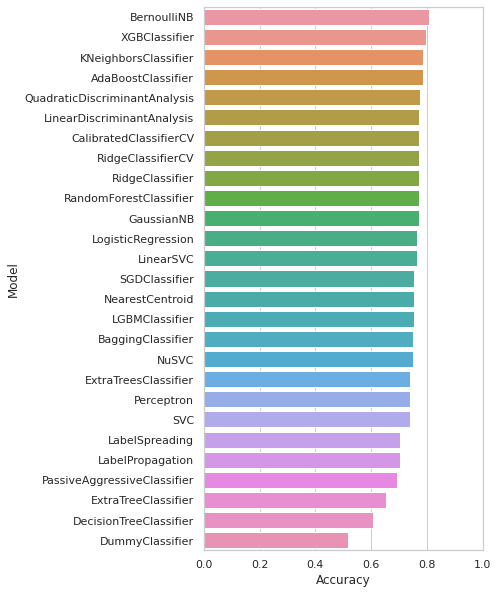

In [108]:
# Plot of Accuracy 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5, 10)) # set figure size 5 by 10
sns.set_theme(style="whitegrid") # set white grid theme

ax = sns.barplot(y=models.index, x="Accuracy", data=models) # take barplot with accuracy on the x-axis and model on the y-axis
ax.set(xlim=(0, 1)) # x-axis is limited within 0 to 1

Plot and Calculate Matthews Correlation Matrix

[(0.0, 1.0)]

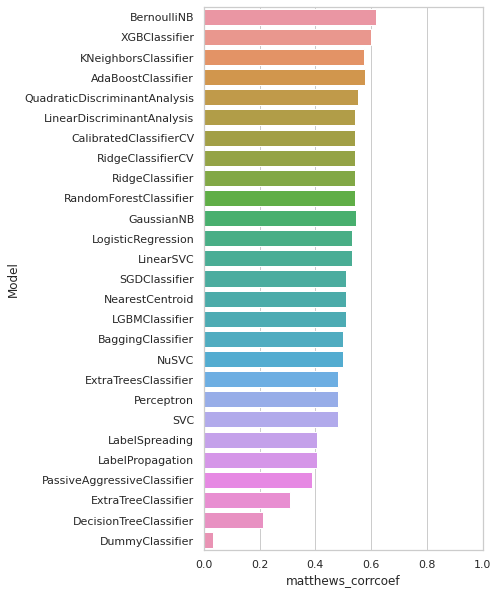

In [109]:
# Plot of MCC(matthews correlation coefficient)

plt.figure(figsize=(5, 10)) # set figure size 5 by 10
sns.set_theme(style="whitegrid") # set white grid theme
ax = sns.barplot(y=models.index, x="matthews_corrcoef", data=models) # take barplot with accuracy on the x-axis and model on the y-axis
ax.set(xlim=(0, 1)) # x-axis is limited within 0 to 1

---

# **Random Forest**

In [110]:
# Build random forest model

from sklearn.ensemble import RandomForestClassifier # import RandomForestClassifier from sklearn.ensemble

rf = RandomForestClassifier(n_estimators=500) # build RandomForestClassifier with number of trees=500

rf.fit(X_train, y_train) # fit RandomForestClassifier on training data

RandomForestClassifier(n_estimators=500)

### **Apply the model to make predictions**

In [111]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

### **Model performance**

In [112]:
feature_train['class'] # print the class column of feature_train

0       positive
1       positive
2       positive
3       positive
4       positive
          ...   
1417    negative
1418    negative
1419    negative
1420    negative
1421    negative
Name: class, Length: 2759, dtype: object

In [113]:
# Simplest and quickest way to obtain the model performance (Accuracy)
rf.score(X_test,y_test)

0.7659574468085106

In [114]:
# Accuracy
from sklearn.metrics import accuracy_score # import accuracy_score form sklearn.metrics

accuracy_score(y_test, y_test_pred) # calculate accuracy score 

0.7659574468085106

In [115]:
# Matthew Correlation Coefficient
from sklearn.metrics import matthews_corrcoef # import matthews_corrcoef form sklearn.metrics

matthews_corrcoef(y_test, y_test_pred) # calculate matthews_corrcoef

0.5323971374999499

In [116]:
# Confusion matrix
from sklearn.metrics import confusion_matrix # import confusion_matrix form sklearn.metrics

confusion_matrix(y_test, y_test_pred) # calculate confusion_matrix

array([[74, 20],
       [24, 70]])

In [117]:
# Classification report
from sklearn.metrics import classification_report # import classification_report form sklearn.metrics

model_report = classification_report(y_train, y_train_pred, target_names=['positive','negative']) # generate classification_report

# write the classification_report in 'model_report.txt' file
with open('model_report.txt','w') as f:
  f.writelines(model_report) 


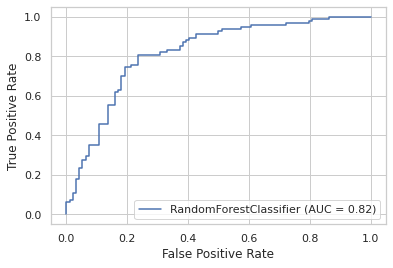

In [118]:
# ROC curve
import matplotlib.pyplot as plt 
from sklearn.metrics import plot_roc_curve # import plot_roc_curve form sklearn.metrics

plot_roc_curve(rf, X_test, y_test)  # plot roc_curve on RandomForestClassifier model's performance on X_test and y_test
plt.show() # show the plot

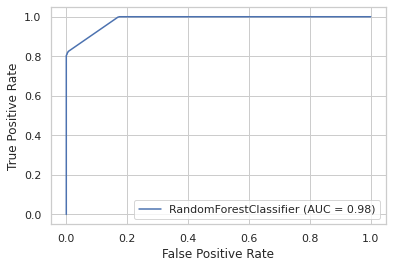

In [119]:
plot_roc_curve(rf, X_train, y_train) # plot roc_curve on RandomForestClassifier model's performance on X_train and y_train
plt.show() # show the plot

### **Feature importance**

In [120]:
# Display Dataframe of the dataset after feature selection (variance threshold)
X_train2

,AAC_A,AAC_C,AAC_D,AAC_E,AAC_F,AAC_G,AAC_H,AAC_I,AAC_K,AAC_L,AAC_M,AAC_N,AAC_P,AAC_Q,AAC_R,AAC_S,AAC_T,AAC_V,AAC_W,AAC_Y
0,27.27,0.00,9.09,0.00,9.09,9.09,0.00,0.00,0.00,0.00,0.00,9.09,9.09,0.00,0.00,0.00,0.00,18.18,0.00,9.09
1,0.00,54.55,0.00,9.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18.18,18.18,0.00,0.00,0.00
2,0.00,0.00,9.09,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,0.00,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
3,0.00,0.00,0.00,18.18,9.09,9.09,9.09,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,9.09,0.00,0.00
4,0.00,0.00,9.09,18.18,18.18,9.09,0.00,0.00,0.00,9.09,9.09,9.09,18.18,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1417,13.33,0.00,3.33,3.33,0.00,13.33,0.00,3.33,26.67,10.00,3.33,3.33,3.33,3.33,0.00,0.00,3.33,0.00,10.00,0.00
1418,6.67,0.00,0.00,3.33,6.67,20.00,3.33,3.33,13.33,13.33,3.33,0.00,3.33,10.00,0.00,6.67,3.33,3.33,0.00,0.00
1419,6.67,20.00,0.00,3.33,0.00,10.00,0.00,6.67,10.00,3.33,0.00,3.33,6.67,0.00,0.00,6.67,6.67,10.00,0.00,6.67
1420,6.67,0.00,3.33,3.33,6.67,0.00,3.33,3.33,3.33,6.67,3.33,16.67,3.33,6.67,10.00,6.67,0.00,13.33,0.00,3.33


In [121]:
# Retrieve feature importance from the RF model
importance = pd.Series(rf.feature_importances_, name = 'Gini')

# Retrieve feature names
feature_names = pd.Series(X_train2.columns, name = 'Feature')

In [122]:
# Combine feature names and Gini values into a Dataframe
df = pd.concat([feature_names, importance], axis=1, names=['Feature', 'Gini'])
df

,Feature,Gini
0,AAC_A,0.05
1,AAC_C,0.04
2,AAC_D,0.09
3,AAC_E,0.08
4,AAC_F,0.04
5,AAC_G,0.05
6,AAC_H,0.02
7,AAC_I,0.05
8,AAC_K,0.09
9,AAC_L,0.07


Text(0.5, 0, 'Feature Importance')

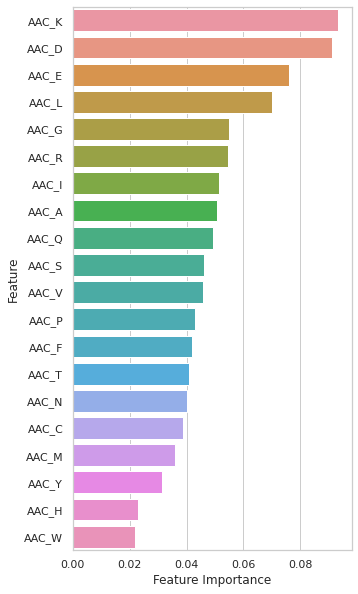

In [123]:
# Plot of feature importance
import matplotlib.pyplot as plt 
import seaborn as sns

# Plot the features based on Gini index in ascending order
df_sorted = df.sort_values('Gini', ascending=False)[:20] # Sort by Gini in descending order; Showing only the top 20 results

plt.figure(figsize=(5, 10)) # set figure size 5 by 10
sns.set_theme(style="whitegrid") # set theme to be whitegrid
ax = sns.barplot(x = 'Gini', y = 'Feature', data = df_sorted) # generate barplot with gini index on the x-axis and feature on the y-axis
plt.xlabel("Feature Importance") # set x label as Feature Importance

---